In [139]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from cardinality_estimation.featurizer import Featurizer
from query_representation.query import load_qrep
from cardinality_estimation.dataset import *
from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup file paths / Download query data

In [140]:
import errno
def make_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [141]:
# TODO
# TRAINDIR = os.path.join(os.path.join("", "queries"), "mlsys1-train")
# VALDIR = os.path.join(os.path.join("", "queries"), "mlsys1-val")
# TESTDIR = os.path.join(os.path.join("", "queries"), "mlsys1-test")

#TRAINDIR = os.path.join(os.path.join("", "queries"), "imdb")

BASEDIR = "/home/pari/learned-cardinalities/"
TRAINDIR = os.path.join(os.path.join(BASEDIR, "queries"), "job2")

TESTDIR = os.path.join(os.path.join("", "queries"), "imdb")

RESULTDIR = os.path.join("", "results")
make_dir(RESULTDIR)

# Query loading helper functions

In [142]:

def load_qdata(fns):
    qreps = []
    for qfn in fns:
        qrep = load_qrep(qfn)
        # TODO: can do checks like no queries with zero cardinalities etc.
        qreps.append(qrep)
        template_name = os.path.basename(os.path.dirname(qfn))
        qrep["name"] = os.path.basename(qfn)
        qrep["template_name"] = template_name
    return qreps

def get_query_fns(basedir, template_fraction=1.0, sel_templates=None):
    fns = []
    tmpnames = list(glob.glob(os.path.join(basedir, "*")))
    assert template_fraction <= 1.0
    
    for qi,qdir in enumerate(tmpnames):
        if os.path.isfile(qdir):
            continue
        template_name = os.path.basename(qdir)
        
        if sel_templates is not None and template_name not in sel_templates:
            continue
        # let's first select all the qfns we are going to load
        qfns = list(glob.glob(os.path.join(qdir, "*.pkl")))
        qfns.sort()
        num_samples = max(int(len(qfns)*template_fraction), 1)
        random.seed(1234)
        qfns = random.sample(qfns, num_samples)
        fns += qfns
    return fns

# Load queries

In [143]:
# set template_fraction <= 1.0 to test quickly w/ smaller datasets
# train_qfns = get_query_fns(TRAINDIR, template_fraction = 0.001)
# val_qfns = get_query_fns(VALDIR, template_fraction = 1.0)
# test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0)

train_qfns = get_query_fns(TRAINDIR, template_fraction = 1.0, sel_templates=["all_job"])
#train_qfns = get_query_fns(TRAINDIR, template_fraction = 1.0, sel_templates=None)

#train_qfns = get_query_fns(TRAINDIR, template_fraction = 0.1, sel_templates=None)
val_qfns = []
#test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0, sel_templates=["2a"])
test_qfns = []
print("Selected {} training queries, {} validation queries, {} test queries".\
      format(len(train_qfns), len(val_qfns), len(test_qfns)))

Selected 110 training queries, 0 validation queries, 0 test queries


In [144]:
TRAINDIR

'/home/pari/learned-cardinalities/queries/job2'

In [145]:
# going to start training the models
trainqs = load_qdata(train_qfns)

In [146]:
import sqlparse

In [165]:
for qrep in trainqs:
    sql = qrep["sql"]
    #if "!=" in sql:
#     if "ci.note" in sql:

#     if "!=" in sql.lower():
#         print(qrep["name"])
#         #print(sqlparse.format(sql, reindent=True, keyword_case='upper'))
#         sqllines = sql.split("\n")
#         for l in sqllines:
#             if "!=" in l:
#                 print(l)
                
    if "= '[us]'" in sql.lower():
        print(qrep["name"])
        print(sqlparse.format(sql, reindent=True, keyword_case='upper'))
    
    jg = qrep["join_graph"]
    for node, data in jg.nodes(data=True):
        if len(data["predicates"]) == 0:
            #print(node, "No Predicates")
            continue
            
#         for di, pred in enumerate(data["pred_vals"]):
#             if "ci" in data["pred_cols"][di]:
#                 print("{} {} {}".format(data["pred_cols"][di], data["pred_types"][di], data["pred_vals"][di]))
            
#         for di, pred in enumerate(data["predicates"]):
#             if "!=" in data["predicates"][di]:
#                 print(data["predicates"][di])
                
#                 print(data["predicates"])
#                 print(data["pred_cols"])
#                 print(data["pred_vals"])
    
    print("******************")

******************
******************
******************
******************
******************
******************
******************
******************
******************
******************
******************
******************
******************
******************
10c.pkl
SELECT COUNT(*)
FROM char_name AS chn,
     cast_info AS ci,
     company_name AS cn,
     company_type AS ct,
     movie_companies AS mc,
     role_type AS rt,
     title AS t
WHERE ci.note LIKE '%(producer)%'
  AND cn.country_code = '[us]'
  AND t.production_year > 1990
  AND t.id = mc.movie_id
  AND t.id = ci.movie_id
  AND ci.movie_id = mc.movie_id
  AND chn.id = ci.person_role_id
  AND rt.id = ci.role_id
  AND cn.id = mc.company_id
  AND ct.id = mc.company_type_id;
******************
******************
******************
******************
******************
******************
******************
******************
******************
15c.pkl
SELECT COUNT(*)
FROM aka_title AS AT,
     company_name AS cn,
     comp

SELECT COUNT(*)
FROM complete_cast AS cc,
     comp_cast_type AS cct1,
     comp_cast_type AS cct2,
     company_name AS cn,
     company_type AS ct,
     info_type AS it1,
     info_type AS it2,
     keyword AS k,
     kind_type AS kt,
     movie_companies AS mc,
     movie_info AS mi,
     movie_info_idx AS mi_idx,
     movie_keyword AS mk,
     title AS t
WHERE cct1.kind = 'crew'
  AND cct2.kind != 'complete+verified'
  AND cn.country_code != '[us]'
  AND it1.info = 'countries'
  AND it2.info = 'rating'
  AND k.keyword IN ('murder',
                    'murder-in-title',
                    'blood',
                    'violence')
  AND kt.kind IN ('movie',
                  'episode')
  AND mc.note NOT LIKE '%(USA)%'
  AND mc.note LIKE '%(200%)%'
  AND mi.info IN ('Sweden',
                  'Norway',
                  'Germany',
                  'Denmark',
                  'Swedish',
                  'Danish',
                  'Norwegian',
                  'German',
         

In [115]:
alljoinys = []
pg_alljoinys = []

for qrep in trainqs:
    #jg = qrep["join_graph"]
    for ed in qrep["subset_graph"].edges(data=True):
        data = ed[2]
        if "join_key_cardinality" not in data:
            continue
            
        for k,v in data["join_key_cardinality"].items():
            alljoinys.append(v["actual"])
            pg_alljoinys.append(v["expected"])

In [117]:
print(np.corrcoef(alljoinys, pg_alljoinys)[0,1])
#print(np.corrcoef(regexys, pg_regexys)[0,1])

0.5463019765176689


(0.0, 1000000.0)

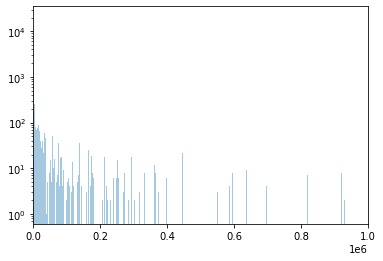

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(alljoinys, kde=False, bins=10000)
plt.yscale("log")
plt.xlim([0, 1*1e6])

(0.0, 1000000.0)

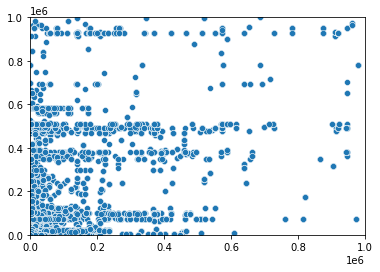

In [119]:
sns.scatterplot(x=alljoinys, y=pg_alljoinys)
plt.xlim([0, 1*1e6])
plt.ylim([0, 1*1e6])

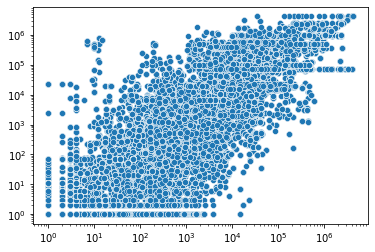

In [120]:
sns.scatterplot(x=alljoinys, y=pg_alljoinys)
plt.xscale("log")
plt.yscale("log")

In [121]:
allys = []
regexys = []
nonregexys = []

pg_allys = []
pg_regexys = []
pg_nonregexys = []

regex_single = []
nonregex_single = []

pg_regex_single = []
pg_nonregex_single = []

allselys = []
regexselys = []
nonregexselys = []

pg_allselys = []
pg_regexselys = []
pg_nonregexselys = []

TIMEOUT_CARD = 150001000000

for qrep in trainqs:
    jg = qrep["join_graph"]
    for node,data in qrep["subset_graph"].nodes(data=True):
        actual = data["cardinality"]["actual"]
        pg = data["cardinality"]["expected"]
        total = float(data["cardinality"]["total"])
        
        if actual >= TIMEOUT_CARD or pg >= TIMEOUT_CARD:
            continue
        
        allys.append(actual)
        allselys.append(actual/total)
        
        pg_allys.append(pg)
        pg_allselys.append(pg/total)
        
        is_regex = False
        
        for alias in node:
            for pt in jg.nodes()[alias]["pred_types"]:
                if "like" in pt:
                    is_regex = True
                    break
            if is_regex:
                regexys.append(actual)
                pg_regexys.append(pg)
                
                regexselys.append(actual/total)
                pg_regexselys.append(pg/total)
            else:
                nonregexys.append(actual)
                pg_nonregexys.append(pg)
                
                nonregexselys.append(actual/total)
                pg_nonregexselys.append(pg/total)
                
                        
        if len(node) == 1:
            if is_regex:
                regex_single.append(actual)
                pg_regex_single.append(pg)
            else:
                nonregex_single.append(actual)
                pg_nonregex_single.append(pg)

In [122]:
print(np.corrcoef(nonregex_single, pg_nonregex_single)[0,1])
print(np.corrcoef(nonregexys, pg_nonregexys)[0,1])

print(np.corrcoef(regex_single, pg_regex_single)[0,1])
print(np.corrcoef(regexys, pg_regexys)[0,1])

0.9999845843914217
0.8089394799151749
0.9839465760899316
0.6743389200556336


In [124]:
print(np.max(regexys), np.max(nonregexys))
# JOB MAX: 5607347034.0 5607347034.0

546272773.0 3185061897.0


In [125]:
TIMEOUT_CARD - 23795596119

126205403881

In [126]:
TIMEOUT_CARD - 5607347034.0

144393652966.0

/home/pari/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


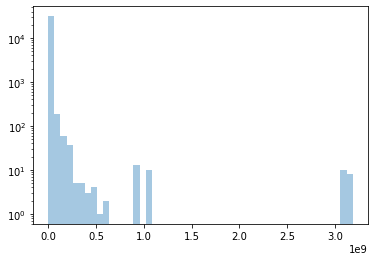

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(allys, kde=False)
plt.yscale("log")
#plt.xscale("log")

(0.0, 1000000.0)

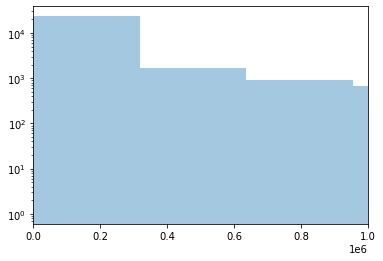

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(allys, kde=False, bins=10000)
plt.yscale("log")
plt.xlim([0,1e6])
#plt.xscale("log")

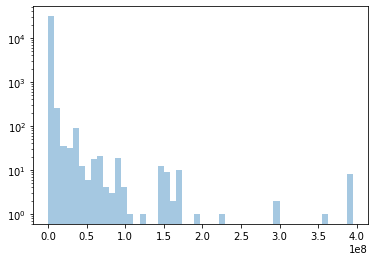

In [130]:
sns.distplot(pg_allys, kde=False)
plt.yscale("log")

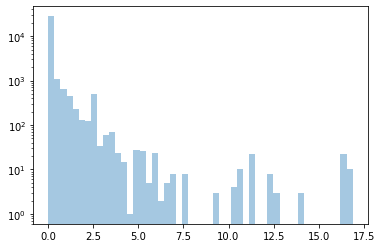

In [76]:
sns.distplot(allselys, kde=False)
plt.yscale("log")

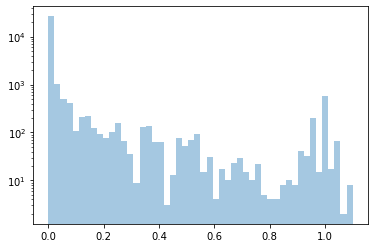

In [77]:
sns.distplot(pg_allselys, kde=False)
plt.yscale("log")

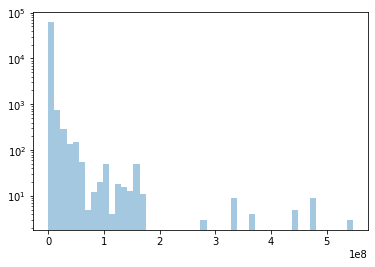

In [78]:
sns.distplot(regexys, kde=False)
plt.yscale("log")

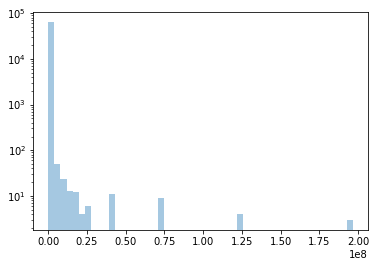

In [79]:
sns.distplot(pg_regexys, kde=False)
plt.yscale("log")

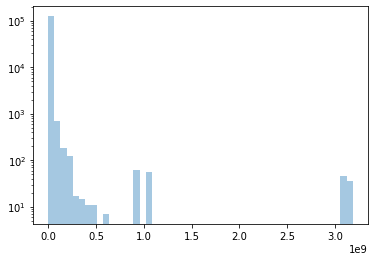

In [80]:
sns.distplot(nonregexys, kde=False)
plt.yscale("log")

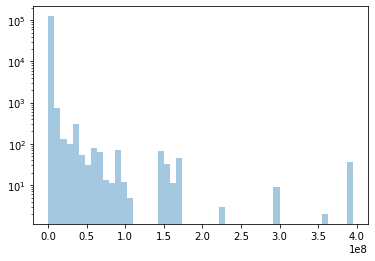

In [81]:
sns.distplot(pg_nonregexys, kde=False)
plt.yscale("log")

(0.0, 100000000.0)

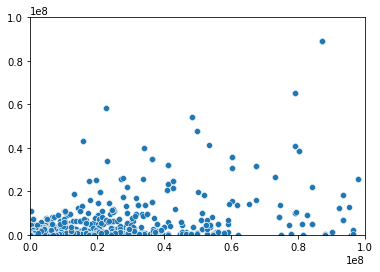

In [97]:
sns.scatterplot(x=allys, y=pg_allys)

plt.xlim([0, 1*1e8])
plt.ylim([0, 1*1e8])

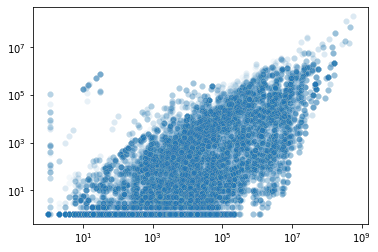

In [83]:
sns.scatterplot(x=regexys, y=pg_regexys, alpha=0.05)
# plt.xlim([0, 0.2*1e9])
# plt.ylim([0, 0.2*1e9])

# plt.xlim([0, 0.2*1e8])
# plt.ylim([0, 0.2*1e8])

plt.yscale("log")
plt.xscale("log")

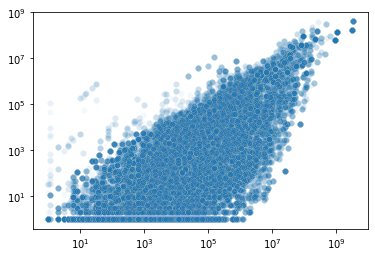

In [84]:
sns.scatterplot(x=nonregexys, y=pg_nonregexys, alpha=0.05)
plt.yscale("log")
plt.xscale("log")
# plt.xlim([0, 0.2*1e9])
# plt.ylim([0, 0.2*1e9])
# plt.xlim([0, 0.2*1e8])
# plt.ylim([0, 0.2*1e8])

(0.0, 1000000.0)

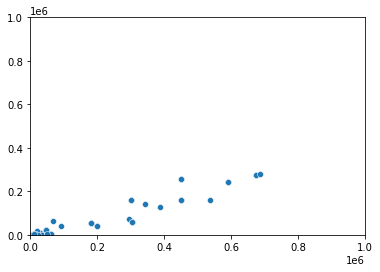

In [31]:
sns.scatterplot(x=regex_single, y=pg_regex_single)
plt.xlim([0, 1e6])
plt.ylim([0, 1e6])

(0.0, 1000000.0)

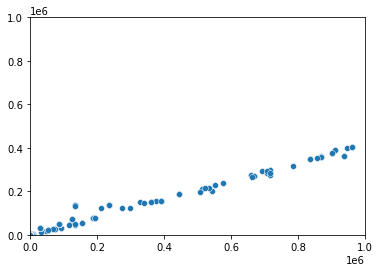

In [32]:
sns.scatterplot(x=nonregex_single, y=pg_nonregex_single)
plt.xlim([0, 1e6])
plt.ylim([0, 1e6])

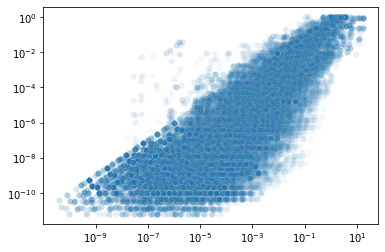

In [33]:
sns.scatterplot(x=allselys, y=pg_allselys, alpha=0.05)
plt.yscale("log")
plt.xscale("log")
# plt.xlim([0, 0.005])
# plt.ylim([0, 0.005])

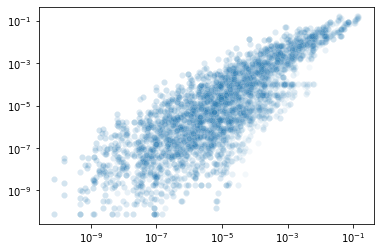

In [344]:
sns.scatterplot(x=regexselys, y=pg_regexselys, alpha=0.05)
plt.yscale("log")
plt.xscale("log")
# plt.xlim([0, 0.005])
# plt.ylim([0, 0.005])

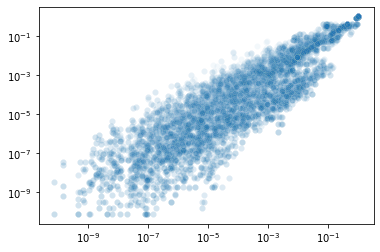

In [345]:
sns.scatterplot(x=nonregexselys, y=pg_nonregexselys, alpha=0.05)
#plt.xlim([0, 0.0001])
#plt.ylim([0, 0.0001])
plt.yscale("log")
plt.xscale("log")
# plt.xlim([0, 0.0001])
# plt.ylim([0, 0.0001])

In [326]:
np.log(allselys)

array([-0.225, -0.001, -3.597, ..., -12.658, -14.557, -14.600])